In [347]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dropout ,Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,AveragePooling2D,Conv2DTranspose, Input, Concatenate, Add, BatchNormalization, Activation, MultiHeadAttention
from ipywidgets import IntProgress
from IPython.display import display
import os
import cv2
import PIL
import PIL.Image
import json
import random
from random import randint as rand
from os import listdir
from os.path import isfile, join
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [372]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_layers_to_keep = 154
output_tensor = base_model.layers[num_layers_to_keep - 1].output
output_tensor = Dropout(0.4)(output_tensor)
clipped_model = tf.keras.Model(inputs=base_model.input, outputs=output_tensor)
for layer in clipped_model.layers[:50]:
    layer.trainable = False
clipped_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_28[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,174,592 (8.30 MB)

 Non-trainable params: 83,392 (325.75 KB)

In [20]:
for layer in clipped_model.layers[100:]:
    layer.trainable = True

In [392]:
import tensorflow as tf
import json
from PIL import Image
import matplotlib.image as mpimg

path_to_images = "C:\\Users\\Ильяс\\.cache\\roboflow\\PPE.v14i.yolokeras\\update__annotations.txt"


def fill(shape, value):
    for ax in shape:
        value = tf.repeat(tf.expand_dims(value, axis = 1), ax, axis = 1)
    return value 

def IoU(boxA, boxB):
        boxes = tf.concat([tf.expand_dims(boxA, axis = 0), tf.expand_dims(boxB, axis = 0)], axis = 0)
        A = tf.reduce_max(boxes, axis = 0)
        B = tf.reduce_min(boxes, axis = 0)
        xA = A[:, 0]
        yA = A[:, 1]
        xB = B[:, 2]
        yB = B[:, 3]

        interW = tf.nn.relu(xB - xA + 1)
        interH = tf.nn.relu(yB - yA + 1)

        interArea = interW * interH
        boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
        boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

        iou = interArea / tf.cast(boxAArea + boxBArea - interArea, dtype=tf.float32)
        return iou


def generate_void_boxes(gt, image_size = 224, n_void = 2):
    void_boxes_center = tf.random.uniform([n_void*10, 2], minval=0, maxval = image_size)
    void_boxes_size = tf.random.uniform([n_void*10, 2], minval= 0, maxval = image_size / 2)
    void_boxes_lu = void_boxes_center - void_boxes_size
    void_boxes_rd = void_boxes_center + void_boxes_size
    void_boxes = tf.concat([void_boxes_lu, void_boxes_rd], axis = 1)
    void_boxes = tf.clip_by_value(void_boxes, 0, image_size)
    
    num_void = void_boxes.shape[0]
    num_gt = gt.shape[0]
    r_void = tf.repeat(tf.expand_dims(void_boxes, axis = 0), num_gt, axis = 0)
    r_gt = tf.tile(tf.expand_dims(gt, axis=1), multiples=[1, num_void, 1])
    r_gt = tf.reshape(r_gt, shape=[-1, num_void, 4])
    r_void = tf.reshape(r_void, [-1, 4])
    r_gt = tf.reshape(r_gt, [-1, 4])
    iou = IoU(r_void, r_gt)
    iou = tf.reshape(iou, [num_gt, num_void])
    max_iou_arg = tf.argmax(iou, axis = 0)
    corresponding_void = void_boxes
    iou_rates = tf.reduce_max(iou, axis = 0)
    indexes = tf.argsort(iou_rates, direction='ASCENDING')
    corresponding_void = tf.gather(corresponding_void, indexes)
    iou_rates = tf.gather(iou_rates, indexes)
    resulted_boxes = []
    for i in range(iou_rates.shape[0]):
        if(iou_rates[-i] < 0.3):
            resulted_boxes.append(corresponding_void[-i])
        if len(resulted_boxes) == n_void:
            break
    return tf.stack(resulted_boxes)


def preprocess_image(img_filename):
    img = tf.io.read_file(img_filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 128 - 1  # Нормализация [-1, 1]
    return img

def generate_void_boxes(gt_boxes, image_size=224, n_void=2):
    """Генерация void-боксов (не содержащих объекты)"""
    # Ваша реализация этой функции
    pass

fixed_num_boxes = 20  # Фиксированное количество боксов на изображение

import random
import tensorflow as tf
import os

import random
import tensorflow as tf
import os

def generator():
    # Путь к файлу с изображениями
    annotations_path = 'C:\\Users\\Ильяс\\.cache\\roboflow\\PPE.v14i.yolokeras\\update__annotations.txt'
    
    # Читаем список изображений
    with open(annotations_path, 'r') as f:
        image_paths = [line.strip() for line in f.readlines() if line.strip()]
    
    for image_path in image_paths:
        # Полный путь к изображению
        full_image_path = image_path
        
        # Соответствующий файл с разметкой (YOLO формат)
        label_path = os.path.join(
            'C:\\Users\\Ильяс\\.cache\\roboflow\\PPE.v14i.yolokeras\\train\\labels',
            os.path.basename(image_path) + '.txt'
        )
        
        # Загружаем изображение
        try:
            image = preprocess_image(full_image_path)
            image = tf.image.resize(image, (224, 224))
            
            # Случайный выбор угла поворота (0, 90, 180 или 270 градусов)
            rotation = random.choice([0, 1, 2, 3])
            
            # Поворот изображения
            rotated_image = tf.image.rot90(image, k=rotation)
            
        except:
            continue  # Пропускаем битые изображения
        
        # Читаем разметку
        boxes = []
        classes = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    
                    # Парсим YOLO формат: class_id x_center y_center width height
                    parts = line.split()
                    class_id = int(parts[0])
                    x, y = float(parts[1]) * 224, float(parts[2]) * 224
                    w, h = float(parts[3]) * 224, float(parts[4]) * 224
                    
                    # Корректировка bounding boxes в зависимости от поворота
                    if rotation == 1:  # 90 градусов
                        new_x = y
                        new_y = 224 - x - w
                        new_w = h
                        new_h = w
                    elif rotation == 2:  # 180 градусов
                        new_x = 224 - x - w
                        new_y = 224 - y - h
                        new_w = w
                        new_h = h
                    elif rotation == 3:  # 270 градусов
                        new_x = 224 - y - h
                        new_y = x
                        new_w = h
                        new_h = w
                    else:  # 0 градусов (без поворота)
                        new_x, new_y, new_w, new_h = x, y, w, h
                    
                    boxes.append([new_x, new_y, new_w, new_h])
                    classes.append([class_id])
        
        # Добавляем void-боксы, если нужно
        if boxes:
            boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
            void_boxes = generate_void_boxes(boxes_tensor, n_void=2)
            
            if void_boxes is not None and void_boxes.shape[0] > 0:
                boxes.extend(void_boxes.numpy().tolist())
                classes.extend([[0]] * void_boxes.shape[0])  # Класс 0 для void-боксов
        
        # Приводим к фиксированному количеству боксов
        if len(boxes) > fixed_num_boxes:
            boxes = boxes[:fixed_num_boxes]
            classes = classes[:fixed_num_boxes]
        elif len(boxes) < fixed_num_boxes:
            # Дополняем нулевыми боксами
            pad_size = fixed_num_boxes - len(boxes)
            boxes.extend([[0, 0, 0, 0]] * pad_size)
            classes.extend([[0]] * pad_size)
        
        # Конвертируем в тензоры
        boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
        classes_tensor = tf.convert_to_tensor(classes, dtype=tf.int32)
        
        yield rotated_image, boxes_tensor, classes_tensor
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                                                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                                        tf.TensorSpec(shape=(None, 1), dtype=tf.int32)))
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(50)

In [393]:
gen = generator()

In [394]:
next(gen)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 0.21986641,  0.6808039 ,  0.9921875 ],
         [ 0.18973249,  0.65067   ,  0.96317   ],
         [ 0.19272174,  0.6536592 ,  0.9661592 ],
         ...,
         [-0.49947134, -0.44478384, -0.57982796],
         [-0.24091029, -0.1640198 , -0.31915495],
         [-0.35008693, -0.23963507, -0.4459906 ]],
 
        [[ 0.19698668,  0.6579242 ,  0.9704242 ],
         [ 0.17354918,  0.6344867 ,  0.9469867 ],
         [ 0.18470982,  0.64564735,  0.95814735],
         ...,
         [-0.4544789 , -0.37974137, -0.53718686],
         [-0.60789585, -0.5180921 , -0.6886517 ],
         [-0.44832742, -0.3449711 , -0.5607317 ]],
 
        [[ 0.18805803,  0.6489955 ,  0.9614955 ],
         [ 0.1796875 ,  0.640625  ,  0.953125  ],
         [ 0.19854096,  0.6594785 ,  0.9719785 ],
         ...,
         [-0.5688328 , -0.4750828 , -0.6469578 ],
         [-0.45603582, -0.36228582, -0.5375092 ],
         [-0.22607808, -0.14795308, -0.3432656

In [272]:
for data in dataset.take(1):
    pass

In [395]:
inputs = Input((3, 3, 1280))
x = inputs
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(6, activation = 'softmax')(x)
classifier_network = keras.Model(inputs, outputs)
classifier_network.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)          │ (None, 3, 3, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 128)                 │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,475,462 (5.63 MB)

 Trainable params: 1,475,462 (5.63 MB)

 Non-trainable params: 0 (0.00 B)

In [396]:
class ClassifierModel(keras.Model):
    def __init__(self, network, base_network):
        super().__init__()
        self.network = network
        self.base_network = base_network
        self.lr = 1e-5
        self.step_counter = 0
        self.colors = tf.concat([[[0,0,0]], tf.random.uniform([6, 3], 0, 1)], axis=0)  # 6 классов
        self.optimizer = tf.keras.optimizers.Adam(self.lr)
        self.base_optimizer = tf.keras.optimizers.Adam(1e-5)
        self.crossentropy = tf.keras.losses.CategoricalCrossentropy()
    
    def draw_box(self, image, box, color=(255, 0, 0)):
        image = cv2.rectangle(image, 
                            (int(tf.clip_by_value(box[0], 0, 244)), int(tf.clip_by_value(box[1], 0, 244))), 
                            (int(tf.clip_by_value(box[2], 0, 244)), int(tf.clip_by_value(box[3], 0, 244))),
                            color, 1)
        return image

    def roi_pool(self, boxes, feature_map, pool_size=3, image_size=224):
        # Нормализуем координаты боксов к [0,1]
        boxes_normalized = boxes / image_size
        
        # Создаем индексы для каждого бокса (все относятся к 0-му изображению в батче)
        box_indices = tf.zeros([tf.shape(boxes)[0]], dtype=tf.int32)
        
        # Добавляем размерность батча к feature map
        batched_feature_map = tf.expand_dims(feature_map, axis=0)
        
        # Применяем операцию
        pooled_regions = tf.image.crop_and_resize(
            batched_feature_map,
            boxes_normalized,
            box_indices,
            [pool_size, pool_size]
        )
        
        return pooled_regions

    def testing(self):
        for data in dataset.take(1):
            image, bounding_boxes, classes = data
        
        image = tf.expand_dims(image, axis=0)
        feature_map = self.base_network(image)
        rois = self.roi_pool(bounding_boxes, feature_map[0])
        pred_probs = self.network(rois)
        print(pred_probs)
        pred_classes = tf.argmax(pred_probs, axis=1)
        print(classes[:, 0])
        print(pred_classes)
        image = ((image+1)/2).numpy()[0]
        for box_n in range(bounding_boxes.shape[0]):
            r = float(self.colors[pred_classes[box_n]].numpy()[0])
            g = float(self.colors[pred_classes[box_n]].numpy()[1])
            b = float(self.colors[pred_classes[box_n]].numpy()[2])
            image = self.draw_box(image, bounding_boxes[box_n], color=(r, g, b))
        plt.imshow(image)

    @tf.function    
    def train_step(self, image, bounding_boxes, classes):
        image = tf.expand_dims(image, axis=0)
        classes = classes[:, 0]
        with tf.GradientTape() as tape, tf.GradientTape() as base_tape:
            feature_map = self.base_network(image, training=True)
            rois = self.roi_pool(bounding_boxes, feature_map[0])
            pred_probs = self.network(rois, training=True)
            gt_probs = tf.one_hot(classes, 6)  # 6 классов
            loss = self.crossentropy(gt_probs, pred_probs)
        
        gradients = tape.gradient(loss, self.network.trainable_variables)
        base_gradients = base_tape.gradient(loss, self.base_network.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))
        self.base_optimizer.apply_gradients(zip(base_gradients, self.base_network.trainable_variables))
        return loss


model = ClassifierModel(classifier_network, clipped_model)

tf.Tensor(
[[5.9539972e-05 2.2367392e-01 2.8247645e-02 4.1314665e-02 6.2517798e-01
  8.1526272e-02]
 [8.5447580e-05 2.1551296e-01 7.0601809e-01 1.8415947e-02 2.5371907e-02
  3.4595612e-02]
 [4.9743068e-07 6.9217181e-06 2.2560507e-05 2.8228515e-04 9.9716920e-01
  2.5185039e-03]
 [2.3425973e-06 5.8908452e-04 8.3824503e-05 2.3741908e-03 9.3901646e-01
  5.7933997e-02]
 [3.1047373e-05 2.1559954e-02 2.4005832e-01 1.2284413e-01 6.0149336e-01
  1.4013132e-02]
 [3.0140916e-06 7.1095854e-01 2.6127195e-01 1.8334102e-02 6.3403943e-03
  3.0920568e-03]
 [9.9999678e-01 4.0768856e-07 2.4547326e-09 2.8254569e-06 1.7698394e-08
  3.2420473e-08]
 [9.9999678e-01 4.0768856e-07 2.4547326e-09 2.8254569e-06 1.7698394e-08
  3.2420473e-08]
 [9.9999678e-01 4.0768856e-07 2.4547326e-09 2.8254569e-06 1.7698394e-08
  3.2420473e-08]
 [9.9999678e-01 4.0768856e-07 2.4547326e-09 2.8254569e-06 1.7698394e-08
  3.2420473e-08]
 [9.9999678e-01 4.0768856e-07 2.4547326e-09 2.8254569e-06 1.7698394e-08
  3.2420473e-08]
 [9.999967

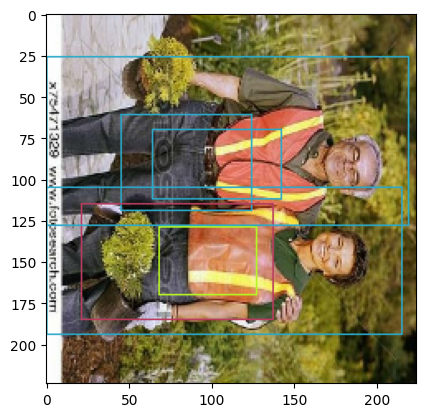

In [406]:
model.testing()

эпоха 0
ошибка: 0.017741549760103226


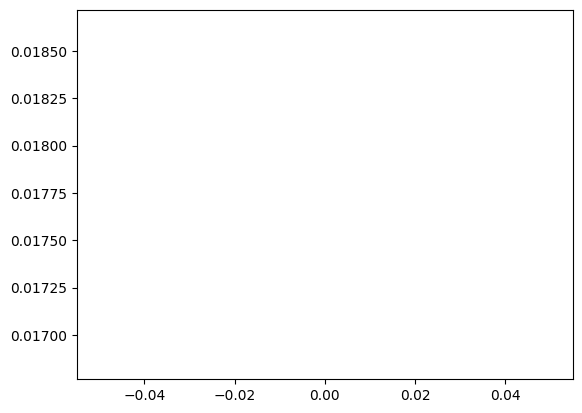

KeyboardInterrupt: 

In [405]:

epochs = 500
hist = np.array(np.empty([0]))
best_loss = 100000
from IPython.display import clear_output
for epoch in range(epochs):
    midloss = 0
    for step, x in enumerate(dataset):
        
        image, bounding_boxes, classes = x
        loss = model.train_step(image, bounding_boxes, classes)
           
        midloss += loss
        if(step % 100 == 99):  
            clear_output(wait=True)
            print('эпоха ' + str(epoch))
            print('ошибка: ' + str(float(midloss/100)))
           
            hist = np.append(hist, float(midloss/100))
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()
            if (midloss/100 < best_loss):
                best_loss = midloss/100
                model.network.save('b_classifier.h5')
                model.base_network.save('b_base_classifier.h5')
            midloss = 0
     

In [404]:
model.network.save('classifier.h5')
model.base_network.save('base_classifier.h5')